## Fuente del dataset

Los datos utilizados en este trabajo provienen del repositorio público de **Kaggle**, específicamente del dataset:

**Student exam score dataset analysis**  
Disponible en: [https://www.kaggle.com/datasets/grandmaster07/student-exam-score-dataset-analysis](https://www.kaggle.com/datasets/grandmaster07/student-exam-score-dataset-analysis)  

Este dataset contiene información sobre el desempeño académico de estudiantes en exámenes, junto con variables relacionadas con sus hábitos de estudio, sueño, asistencia y calificaciones previas. Sus columnas principales son:

- `student_id`: identificador único del estudiante  
- `student_study_hours`: horas de estudio  
- `student_sleep_hours`: horas de sueño  
- `student_attendes_percentage`: porcentaje de asistencia  
- `previous_score`: calificación previa  
- `exam_score`: calificación final en el examen  

El dataset se encuentra bajo licencia **ODC Public Domain Dedication and Licence (PDDL)**, lo que permite su uso libre para investigación y análisis.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import json


df = pd.read_csv("student_exam_scores.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
df.head()

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


## 1. Tratamiento de la data.

Se realiza el manejo de nulos, separación de columnas, la normalización y estandarización

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === 1. Cargar DataFrame (ejemplo: ya lo tienes en df) ===
# df = pd.read_csv("students.csv")

# === 2. Eliminar columnas irrelevantes ===
df_clean = df.drop(columns=['student_id'])

# === 3. Revisar valores nulos y duplicados ===
print("Valores nulos:\n", df_clean.isnull().sum())
print("Duplicados:", df_clean.duplicated().sum())

# Opcional: eliminar duplicados si los hubiera
df_clean = df_clean.drop_duplicates()

# === 4. Separar features y target ===
X = df_clean.drop(columns=['exam_score'])
y = df_clean['exam_score']

# === 5. Normalización / estandarización ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo a DataFrame para legibilidad
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nDataset limpio y transformado:")
print(X_scaled.head())

# === 6. Dividir en train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Valores nulos:
 hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64
Duplicados: 0

Dataset limpio y transformado:
   hours_studied  sleep_hours  attendance_percent  previous_scores
0       0.520154     1.458426           -0.192061        -1.395230
1      -1.561083     1.324503           -0.994074        -0.755216
2      -0.722376     1.056656           -0.079498         1.228827
3      -0.877692    -1.220042            1.426035        -0.051201
4       0.861850    -0.148655            1.053170         0.268806


#2. Matriz de correlación

Se modelaron las correlaciones entre las variables numéricas.

                    hours_studied  sleep_hours  attendance_percent  \
hours_studied            1.000000     0.077864           -0.031311   
sleep_hours              0.077864     1.000000            0.000572   
attendance_percent      -0.031311     0.000572            1.000000   
previous_scores          0.069078    -0.194251            0.051958   
exam_score               0.776751     0.188222            0.225713   

                    previous_scores  exam_score  
hours_studied              0.069078    0.776751  
sleep_hours               -0.194251    0.188222  
attendance_percent         0.051958    0.225713  
previous_scores            1.000000    0.431105  
exam_score                 0.431105    1.000000  


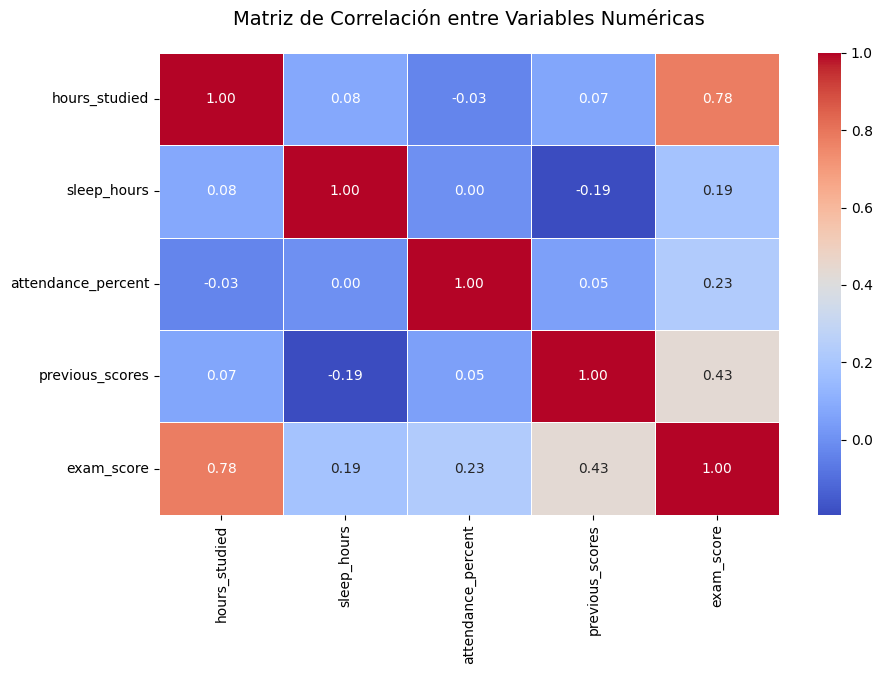

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas
num_df = df.select_dtypes(include=["int64", "float64"])

# Matriz de correlación
corr = num_df.corr()

# Mostrar la matriz en consola
print(corr)

# Graficar heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas", fontsize=14, pad=20)
plt.show()

## 3. Análisis
Se realizó un análisis sobre las clases de calificaciones, dónde se agruparon y se nivelaron las clases haciendo un sobre muestreo para evitar que esta diferencia impacte en las redes neuronales.

score_range
0-10       0
10-20      4
20-30     54
30-40    104
40-50     37
50-55      1
Name: count, dtype: int64


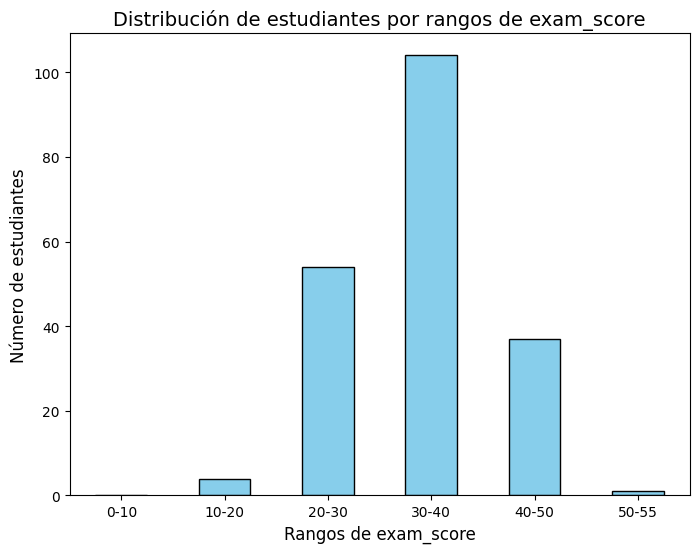

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df

# 1. Definir los rangos (bins)
bins = [0, 10, 20, 30, 40, 50, 55]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-55"]

# 2. Crear columna con el rango correspondiente
df["score_range"] = pd.cut(df["exam_score"], bins=bins, labels=labels, include_lowest=True)

# 3. Contar cuántos estudiantes hay en cada rango
score_counts = df["score_range"].value_counts().sort_index()

print(score_counts)

# 4. Graficar
plt.figure(figsize=(8,6))
score_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Distribución de estudiantes por rangos de exam_score", fontsize=14)
plt.xlabel("Rangos de exam_score", fontsize=12)
plt.ylabel("Número de estudiantes", fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [ ]:
import pandas as pd
from sklearn.utils import resample

# 1. Definir los rangos (bins) nuevamente si no los tienes
bins = [0, 10, 20, 30, 40, 50, 55]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-55"]
df["score_range"] = pd.cut(df["exam_score"], bins=bins, labels=labels, include_lowest=True)

# 2. Encontrar el tamaño máximo entre los rangos
max_count = df["score_range"].value_counts().max()

# 3. Oversampling de cada rango
dfs = []
for label in labels:
    df_label = df[df["score_range"] == label]
    if len(df_label) == 0:
        continue
    # Hacer oversampling para que cada rango tenga max_count filas
    df_label_oversampled = resample(df_label,
                                    replace=True,     # permite duplicar filas
                                    n_samples=max_count,
                                    random_state=42)
    dfs.append(df_label_oversampled)

# 4. Concatenar todos los rangos balanceados
df_balanced = pd.concat(dfs).reset_index(drop=True)

# 5. Comprobar distribución
print(df_balanced["score_range"].value_counts())

score_range
10-20    104
20-30    104
40-50    104
30-40    104
50-55    104
0-10       0
Name: count, dtype: int64


La variable df_balanced ya tine la data balanceada, estandarizada y escalada.

In [ ]:
# Si no existe exam_bin en df_balanced, la creamos
if "exam_bin" not in df_balanced.columns:
    bins   = [0,10,20,30,40,50,55]
    labels = ["0-10","10-20","20-30","30-40","40-50","50-55"]
    df_balanced["exam_bin"] = pd.cut(df_balanced["exam_score"], bins=bins, labels=labels, include_lowest=True)

print(df_balanced["exam_bin"].value_counts().sort_index())


exam_bin
0-10       0
10-20    104
20-30    104
30-40    104
40-50    104
50-55    104
Name: count, dtype: int64


## 4. Modelo
Establecimiento del modelo.

In [ ]:
import numpy as np, random, tensorflow as tf, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Reproducibilidad
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)


In [ ]:
# Usar la base balanceada
data = df_balanced.copy()

# Variables
features = ["hours_studied","sleep_hours","attendance_percent","previous_scores"]
X = data[features].values
y = data["exam_bin"].astype("category").cat.codes.values
class_names = list(data["exam_bin"].astype("category").cat.categories)
num_classes = len(class_names)

# Train/Test Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Escalado
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# One-hot
y_train_oh = to_categorical(y_train, num_classes)
y_test_oh  = to_categorical(y_test,  num_classes)


In [ ]:
def build_and_train_mlp(units=(32,16), activation="relu", initializer="he", batch_size=32):
    # Inicializador
    if initializer == "he":
        init = HeNormal(seed=SEED)
    elif initializer == "glorot":
        init = GlorotUniform(seed=SEED)
    else:
        raise ValueError("initializer debe ser 'he' o 'glorot'")

    # Modelo secuencial
    model = Sequential([
        Dense(units[0], activation=activation, kernel_initializer=init, input_shape=(X_train_s.shape[1],)),
        Dropout(0.2),
        Dense(units[1], activation=activation, kernel_initializer=init),
        Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])

    # Regularización
    es  = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor="val_loss", patience=8, factor=0.5)

    # Entrenamiento
    history = model.fit(
        X_train_s, y_train_oh,
        validation_split=0.2,
        epochs=200,
        batch_size=batch_size,
        callbacks=[es, rlr],
        verbose=0
    )

    # Predicciones y métricas
    y_pred = model.predict(X_test_s).argmax(axis=1)
    acc = (y_pred == y_test).mean()
    f1m = f1_score(y_test, y_pred, average="macro")
   # === 🔹 CÁLCULO Y VISUALIZACIÓN DE GRADIENTES ===
    sample_X = X_train_s[:32]
    sample_y = y_train_oh[:32]

    with tf.GradientTape() as tape:
        preds = model(sample_X, training=True)
        loss_value = tf.keras.losses.categorical_crossentropy(sample_y, preds)

    grads = tape.gradient(loss_value, model.trainable_weights)
    grad_magnitudes = [tf.reduce_mean(tf.abs(g)).numpy() for g in grads if g is not None]

    # Resumen
    print("\n📊 Magnitud promedio de gradientes por capa:")
    for w, g in zip(model.trainable_weights, grad_magnitudes):
        print(f"{w.name:<45} | mean(|grad|) = {g:.6f}")

    # === Gráficas ===
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"Loss ({activation}, {initializer}, batch={batch_size})")
    plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"Accuracy ({activation}, {initializer}, batch={batch_size})")
    plt.xlabel("Épocas"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"✅ Configuración: {activation} | {initializer} | batch={batch_size}")
    print(f"Accuracy: {acc:.3f} | F1-Macro: {f1m:.3f}")
    print("-"*60)

    return {
        "units": units,
        "activation": activation,
        "initializer": initializer,
        "batch_size": batch_size,
        "accuracy": acc,
        "f1_macro": f1m
    }


Definición de distintos hiperparámetros para probar.

In [ ]:
configs = [
    {"units": (32,16), "activation": "relu",    "initializer": "he",     "batch_size": 20},
    {"units": (32,16), "activation": "relu",    "initializer": "glorot", "batch_size": 120},
    {"units": (32,16), "activation": "linear",  "initializer": "he",     "batch_size": 20},
    {"units": (32,16), "activation": "linear",  "initializer": "glorot", "batch_size": 120},
]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📊 Magnitud promedio de gradientes por capa:
kernel                                        | mean(|grad|) = 0.340372
bias                                          | mean(|grad|) = 0.342480
kernel                                        | mean(|grad|) = 0.347659
bias                                          | mean(|grad|) = 0.345692
kernel                                        | mean(|grad|) = 0.902583
bias                                          | mean(|grad|) = 0.374302


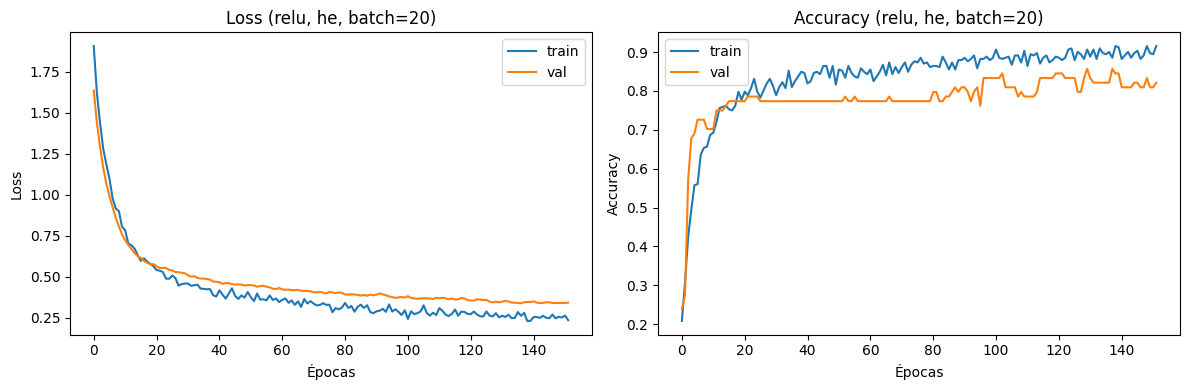

✅ Configuración: relu | he | batch=20
Accuracy: 0.933 | F1-Macro: 0.932
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📊 Magnitud promedio de gradientes por capa:
kernel                                        | mean(|grad|) = 0.627640
bias                                          | mean(|grad|) = 0.610460
kernel                                        | mean(|grad|) = 0.303889
bias                                          | mean(|grad|) = 0.657300
kernel                                        | mean(|grad|) = 0.967964
bias                                          | mean(|grad|) = 0.896164


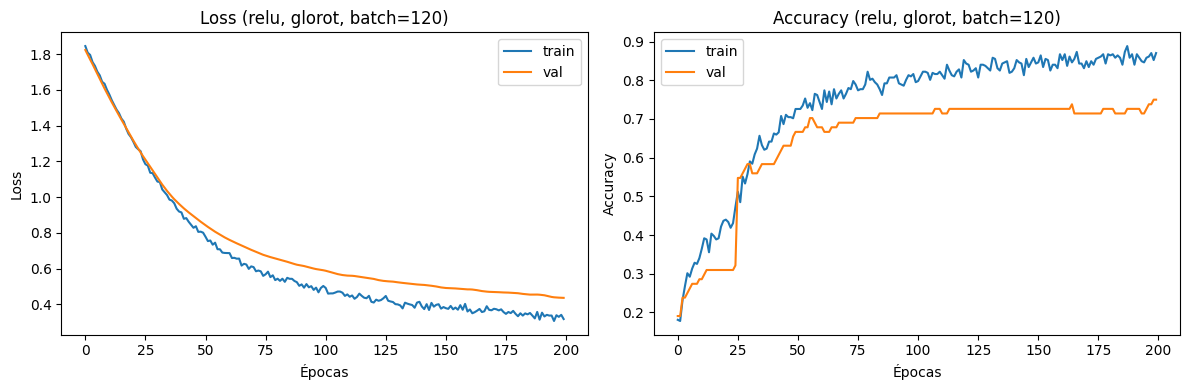

✅ Configuración: relu | glorot | batch=120
Accuracy: 0.913 | F1-Macro: 0.913
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

📊 Magnitud promedio de gradientes por capa:
kernel                                        | mean(|grad|) = 0.594400
bias                                          | mean(|grad|) = 0.247043
kernel                                        | mean(|grad|) = 0.589363
bias                                          | mean(|grad|) = 0.117842
kernel                                        | mean(|grad|) = 1.522446
bias                                          | mean(|grad|) = 0.283801


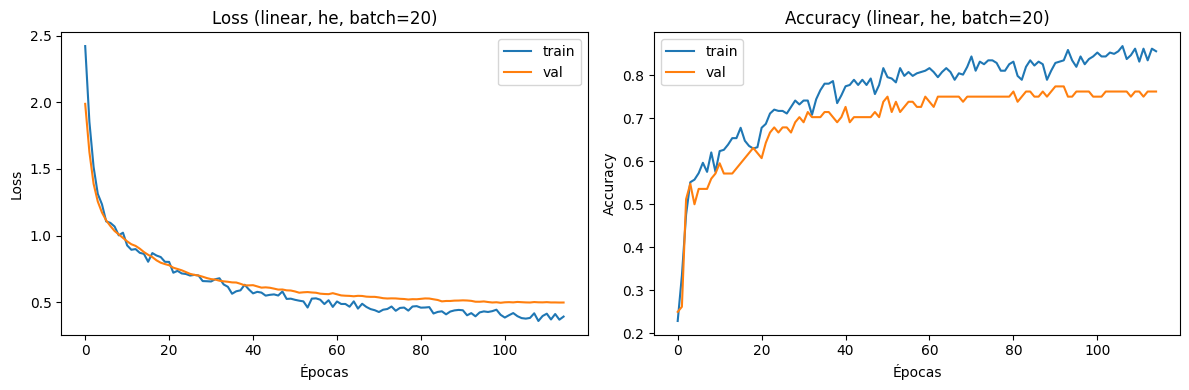

✅ Configuración: linear | he | batch=20
Accuracy: 0.904 | F1-Macro: 0.902
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

📊 Magnitud promedio de gradientes por capa:
kernel                                        | mean(|grad|) = 0.805966
bias                                          | mean(|grad|) = 0.597009
kernel                                        | mean(|grad|) = 0.334839
bias                                          | mean(|grad|) = 0.551102
kernel                                        | mean(|grad|) = 1.514453
bias                                          | mean(|grad|) = 0.854476


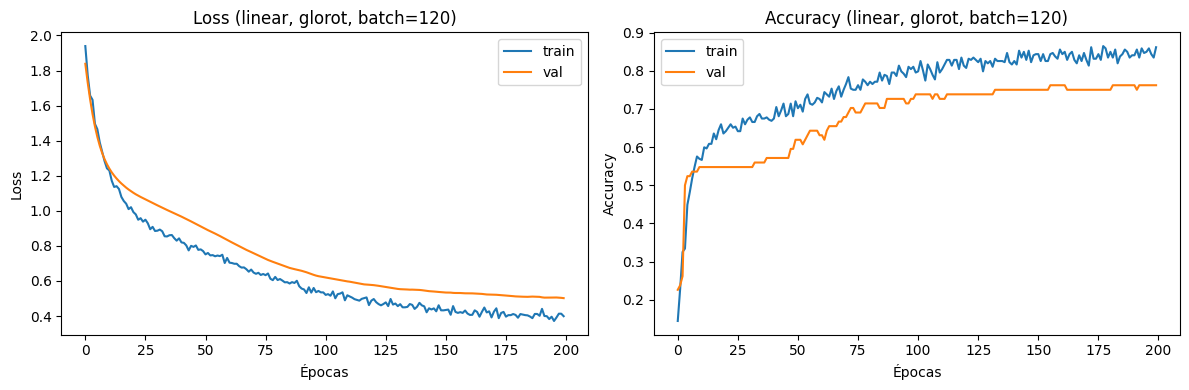

✅ Configuración: linear | glorot | batch=120
Accuracy: 0.894 | F1-Macro: 0.892
------------------------------------------------------------
📊 Resultados comparativos (ordenados por F1-Macro):
      units activation initializer  batch_size  accuracy  f1_macro
0  (32, 16)       relu          he          20  0.932692  0.932387
1  (32, 16)       relu      glorot         120  0.913462  0.912863
2  (32, 16)     linear          he          20  0.903846  0.901829
3  (32, 16)     linear      glorot         120  0.894231  0.891703


In [ ]:
results = [build_and_train_mlp(**cfg) for cfg in configs]

df_results = pd.DataFrame(results).sort_values("f1_macro", ascending=False)
print("📊 Resultados comparativos (ordenados por F1-Macro):")
print(df_results)
